<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Summary</h1>
    <br>The following notebook analyzes which D&D creature stats can increase the likelihood of winning a combat encounter.
    <br>It then gauges cr's relationship to win rate and how to to predict for it.
    <br><h2>Methodology</h2>
    <h3>Generating win data.</h3>
    <li>Monte-Carlo (RNG-Driven) Battle Simulations - Who performs best in a free for all?</li>
    <p>Take each creature and make them fight against the rest in RNG driven simulations.</p>
    <li>Stat Threhold Analysis - Who takes less turns to win?</li>
    <p>Take each creature and calculate who is the most likely winner based on stats alone. Do calculations against all other creatures</p>
    <h3>Generating cr predictions</h3>
    <li>KNN Predictions for 'cr' - Can training on generics provide accurate predictions for different creature types?</li>
    <p>Use generics' stats as features and cr as label to predict for. Check how well this model performs.</p> 
    <br><h2>The best stat(s)?</h2>
    <img src="images/stats-combination.png">
    It was observed that individual stats are not sufficient enough (r <= 0.5) to provide significant results. 
    <br>What were the determinants to the win rate was the combination of multiple stats that gauge combat performance. Such as combining att_num, dmg_avg to gauge damage output; and include hp to gauge overall capability to both deal and take damage.
    <br><h2>Challenge Rating</h2>
    <img src="images/cr_win_relation.png">
    <p>cr or Challenge Rating is a ranking system used to gauge the stats values/scale.<br>
        It's similar in concept to 'creature level' where a higher level increase the base stats more.<br>
        Hence there is significant direct relationship where higher cr/levels increase the likelihood of winning.
    </p>
    <h2>The best creature?</h2>
    <img src="images/cr_win_comparison.png">
    <p>Without a doubt, wizards are the weakest with their cr-win relationship being the lowest.<br>
        Figthers are able to keep up with monster hordes but only until their cr cap of 20<br>
        Lastly monster hordes are more difficult to overcome than single monsters.<br>
        Dungeon masters could utilze the info properly to properly plan and balance the amount and cr level of opponents to spawn.
    </p>
    <h2>Predictions</h2>
    <img src="images/model_predictions.png">
    <p>All the KNN Models were trained using generic's stats features to predict for cr labels.<br>
        In most cases its able to capture the trend, yet the results remain noisy. 
    </p>
    <img src="images/predict-wizards.png">
    <p>The closest prediction may have been wizards but the prediction vs true values are clearly seen trending a more sigmoid manner than linear. 
    </p>
    <img src="images/train_test_split.png">
    <p>To improve results, train test splitting was shown to improve generics predictions.
        <br>It may be recommended to shuffle generics with other creature types before train test splitting to maximize predictions.
    </p>
</div>

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Conclusion</h1>
    <p>
        Overall, we saw that no single stat can directly attribute to win chance.<br>
        Rather it's a combination of different stats that gauge overall performance.<br><br>
        The cr (challenge rating) is a metric used to gauge said different stats' scale and values;<br>
        higher cr == higher stats == more wins.<br><br>
        An attempt was made to create a KNN model predicting for cr using generics as the training set, yet all predictions were unsatisfactory.<br>
        It is suggested that shuffling with other creature sets then performing a train test split could improve the result.<br><br>
        Getting the model right is an important task as it allows players and dungeon masters to create new creatures and learn how their cr metric is currently scored. This can help mitigate unbalanced/unfair matchups where the creature's overpowered stats will affect its win rate.
    </p>
</div>

# Libraries

In [1]:
# Import all necessary libraries

import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install seaborn
import numpy as np
import pandas
import seaborn as sns
import warnings
import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from ipywidgets import FloatProgress
from IPython.display import display, Markdown, Latex
%matplotlib inline

## Debugging Flags

In [2]:
# Debug constants

debug_rounds = False
debug_matches = False
use_crit_rules = True

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Functions</h1>
    Function explanations include added <b>docstrings and comments</b>
</div>

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h2>Value Randomizers</h2>
</div>

In [3]:
def roll(s=1,e=21,n=None):
    '''
    Parameters
    -----------
    s: Minimum range (inclusive)
    e: Maximum range (exlusive)
    n: Number of random integers to return
    
    Description
    -----------
    Utilizes numpy's random int generator to generate n number of RANDOM integers within the range [s, n).

    Use Case
    -----------
    Ideal when desiring random values.

    Returns
    -----------
    array(int [s, e)) of Size n
        n number of random integers. 
        Only returns 1 value if n = None.
    '''
    return np.random.randint(s,e,n)

def roll_adv(s=1,e=21,n=None):
    '''
    Parameters
    -----------
    s: Minimum range (inclusive)
    e: Maximum range (exlusive)
    n: Number of random integers to return
    
    Description
    -----------
    Generates 2 arrays of n number of random integers each within the range [s, e) and selects the HIGHEST value.

    Use Case
    -----------
    Ideal when desiring high values. 
    
    Returns
    -----------
    array(int [s, e)) of Size n
        n number of random integers. 
        Only returns 1 value if n = None.
    '''
    r1 = np.random.randint(s,e,n)
    r2 = np.random.randint(s,e,n)
    if n:
        # Compares both arrays and selects the max from each element comparison.
        return np.fromiter(map(max,r1,r2),int)
    else:
        return max(r1,r2)
    
def roll_dis(s=1,e=21,n=None):
    '''
    Parameters
    -----------
    s: Minimum range (inclusive)
    e: Maximum range (exlusive)
    n: Number of random integers to return
    
    Description
    -----------
    Generates 2 arrays of n number of random integers each within the range [s, e) and selects the LOWEST value.

    Use Case
    -----------
    Ideal when desiring low values. 
    
    Returns
    -----------
    array(int [s, e)) of Size n
        n number of random integers. 
        Only returns 1 value if n = None.
    '''
    r1 = np.random.randint(s,e,n)
    r2 = np.random.randint(s,e,n)
    if n:
        # Element wise operation for min between the 2 arrays
        return np.fromiter(map(min,r1,r2),int)
    else:
        return min(r1,r2)

def roll_mid(s=1,e=21,n=None):
    '''
    Parameters
    -----------
    s: Minimum range (inclusive)
    e: Maximum range (exlusive)
    n: Number of random integers to return
    
    Description
    -----------
    Generates 3 arrays of n number of random integers each within the range [s, e) and selects the MEDIAN value.

    Use Case
    -----------
    Ideal when desiring middle/median values. 
    
    Returns
    -----------
    array(int [s, e)) of Size n
        n number of random integers. 
        Only returns 1 value if n = None.
    '''
    r1 = np.random.randint(s,e,n)
    r2 = np.random.randint(s,e,n)
    r3 = np.random.randint(s,e,n)
    if n:
        # Element wise operation for min among the 3 arrays
        return np.fromiter(map(mid, r1,r2,r3),int)
    else:
        return mid(r1,r2,r3)

def mid(r1,r2,r3):
    '''
    Parameters
    -----------
    r1: Value to compare
    r2: Value to compare
    r3: Value to compare
    
    Description
    -----------
    Compares 3 values and selects the MIDDLE/MEDIAN value.

    Use Case
    -----------
    Helper function for roll_mid(). 
    
    Returns
    -----------
    array(int [s, e)) of Size n
        n number of random integers. 
        Only returns 1 value if n = None.
    '''
    if r2 > r1 > r3 or r3 > r1 > r2:
        return r1
    elif r1 > r2 > r3 or r3 > r2 > r1:
        return r2
    else:
        return r3

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h2>Die Roll Randomizers</h2>
</div>

In [4]:
def d20():
    '''
    Paramters
    -----------
    None

    Description
    -----------
    Utilizes numpy's random int generator to simulate a D&D 20 sided die roll.

    Use case
    -----------
    Rolling for RANDOM die values
    
    Returns
    -----------
    int [1, 21)
         A random integer representing the rolled D20 value
    '''
    return np.random.randint(1,21)

def d20_adv(n=None):
    '''
    Parameters
    -----------
    n : Number of rolls to simulate

    Description
    -----------
    Call roll_adv(n) to generate HIGH D20 values.

    Use case
    -----------
    Rolling for HIGH die values
    
    Returns
    -----------
    list(int [1, 21)) of Size n
         Random integers representing the rolled D20 values.
         Only 1 random integer is returned when n = None.
    '''
    return roll_adv(1,21,n)

def d20_dis(n=None):
    '''
    Parameters
    -----------
    n : Number of rolls to simulate

    Description
    -----------
    Call roll_dis(n) to generate LOW D20 values.

    Use case
    -----------
    Rolling for LOW die values
    
    Returns
    -----------
    list(int [1, 21)) of Size n
         Random integers representing the rolled D20 values.
         Only 1 random integer is returned when n = None.
    '''
    return roll_dis(1,21,n)

def d20_mid(n=None):
    '''
    Parameters
    -----------
    n : Number of rolls to simulate

    Description
    -----------
    Call roll_mid(n) to generate MIDDLE/CENTERED D20 values.

    Use case
    -----------
    Rolling for MIDDLE die values
    
    Returns
    -----------
    list(int [1, 21)) of Size n
         Random integers representing the rolled D20 values.
         Only 1 random integer is returned when n = None.
    '''
    return roll_mid(1,21,n)

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h2>Stats Generators</h2>
</div>

In [5]:
def gen_init(amount,f=roll):
    '''
    Parameters
    -----------
    amount : Number of INITIATIVE stats to generate
    f      : The rolling function to utlize {roll, roll_adv, roll_div, roll_mid}    

    Description
    -----------
    Call the corresponding RNG rolling method f to generate amount of values.

    Use case
    -----------
    Generating RNG INITIATIVE values
    
    Returns
    -----------
    list(int [-5, 6)) of Size amount
         Random integers representing the rolled stat values.
    '''
    return f(-5,6,amount)

def gen_ac(amount,f=roll):
    '''
    Parameters
    -----------
    amount : Number of ARMOR CLASS stats to generate
    f      : The rolling function to utlize {roll, roll_adv, roll_div, roll_mid}    

    Description
    -----------
    Call the corresponding RNG rolling method f to generate amount of values.

    Use case
    -----------
    Generating RNG ARMOR CLASS values
    
    Returns
    -----------
    list(int [13, 22)) of Size amount
         Random integers representing the rolled stat values.
    '''
    return f(13,22,amount)

def gen_hp(amount,f=roll):
    '''
    Parameters
    -----------
    amount : Number of HEALTH POINTS stats to generate
    f      : The rolling function to utlize {roll, roll_adv, roll_div, roll_mid}    

    Description
    -----------
    Call the corresponding RNG rolling method f to generate amount of values.

    Use case
    -----------
    Generating RNG HEALTH POINTS values
    
    Returns
    -----------
    list(int [10, 811)) of Size amount
         Random integers representing the rolled stat values.
    '''
    return f(10,811,amount)

def gen_att_num(amount,f=roll):
    '''
    Parameters
    -----------
    amount : Number of ATTACK stats to generate
    f      : The rolling function to utlize {roll, roll_adv, roll_div, roll_mid}    

    Description
    -----------
    Call the corresponding RNG rolling method f to generate amount of values.

    Use case
    -----------
    Generating RNG ATTACK values
    
    Returns
    -----------
    list(int [1, 6)) of Size amount
         Random integers representing the rolled stat values.
    '''
    return f(1,6,amount)

def gen_hit_mod(amount,f=roll):
    '''
    Parameters
    -----------
    amount : Number of HIT MODIFIER stats to generate
    f      : The rolling function to utlize {roll, roll_adv, roll_div, roll_mid}    

    Description
    -----------
    Call the corresponding RNG rolling method f to generate amount of values.

    Use case
    -----------
    Generating RNG HIT MODIFIER values
    
    Returns
    -----------
    list(int [3, 15)) of Size amount
         Random integers representing the rolled stat values.
    '''
    return f(3,15,amount)

def gen_dam_avg(amount,f=roll):
    '''
    Parameters
    -----------
    amount : Number of DAM AVG stats to generate
    f      : The rolling function to utlize {roll, roll_adv, roll_div, roll_mid}    

    Description
    -----------
    Call the corresponding RNG rolling method f to generate amount of values.

    Use case
    -----------
    Generating RNG DAM AVG values
    
    Returns
    -----------
    list(int [2, 62)) of Size amount
         Random integers representing the rolled stat values.
    '''    
    return f(2,62,amount)

In [6]:
def create_randoms(size,f=roll):
    '''
    Parameters
    -----------
    size : Number of creature stats to generate
    f    : The rolling function to utlize {roll, roll_adv, roll_div, roll_mid}    

    Description
    -----------
    Generate a dataframe to store the generated `size` number of creature stats.
    Initialize with the following defaults:
        name = '',
        cr = 0,
        ac = gen_ac,
        hp = gen_hp,
        init = gen_init,
        att_num = gen_att_num,
        hit_mod = gen_hit_mod,
        dam_avg = gen_dam_avg

    Use case
    -----------
    Generating the stats for creatures
    
    Returns
    -----------
    pd.Dataframe() of `size` rows
         Creatures with stats: 
             name,cr,ac,hp,init,att_num,hit_mod,dam_avg.
    '''
    
    
    randoms = pandas.DataFrame()
    randoms['name'] = np.repeat([''],size)
    randoms['cr'] = np.zeros(size)
    randoms['ac'] = gen_ac(size)
    randoms['hp'] = gen_hp(size)
    randoms['init'] = gen_init(size)
    randoms['att_num'] = gen_att_num(size)
    randoms['hit_mod'] = gen_hit_mod(size)
    randoms['dam_avg'] = gen_dam_avg(size)
    return randoms

In [7]:
def create_progressives(size,f=roll):
    '''
    Parameters
    -----------
    size : Number of creature stats to generate
    f    : The rolling function to utlize {roll, roll_adv, roll_div, roll_mid}    

    Description
    -----------
    Similar to create_randoms() in creating a dataframe of creature stats.
    However with an additional step of sorting each column's stats.

    Use case
    -----------
    Generating sorted stats for creatures
    
    Returns
    -----------
    pd.Dataframe() of `size` rows
         Creatures with sorted stats: 
             name,cr,ac,hp,init,att_num,hit_mod,dam_avg.
    '''
    progs = pandas.DataFrame()
    progs['name'] = np.repeat([''],size)
    progs['cr'] = np.zeros(size)
    ac = np.sort(gen_ac(size))
    progs['ac'] = ac
    hp = np.sort(gen_hp(size))
    progs['hp'] = hp
    init = np.sort(gen_init(size))
    progs['init'] = init
    att_num = np.sort(gen_att_num(size))
    progs['att_num'] = att_num
    hit_mod = np.sort(gen_hit_mod(size))
    progs['hit_mod'] = hit_mod
    dam_avg = np.sort(gen_dam_avg(size))
    progs['dam_avg'] = dam_avg
    return progs

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h2>Battles/Monte Carlo Simulation Evaluation</h2>
</div>

In [8]:
def do_attack( attacker, target ):
    '''
    Parameters
    -----------
    attacker : Damage dealer
    target   : Damage recipient    

    Description
    -----------
    Repeat the attack pattern based on attacker's att_num number:

    Calculate the attack chance and perform calculations against the target's stats to see if it would hit.
    On hit, target's hp will be reduced.
    
    Use case
    -----------
    Attacking a unit.
    
    Returns
    -----------
    array()
        [0] : attacker's stats
        [1] : target's stats
    '''
    
    # DEBUG PRINT IF FLAG IS ON
    if debug_rounds:
        print ("        %s makes %d attacks against %s" % (attacker.name, attacker.att_num, target.name))
    
    # ATTACK FOR NUMBER OF TIMES
    for _ in np.arange(attacker.att_num):
        # CALCULATE THE ATTACK CHANCE
        attack = d20() + attacker.hit_mod

        # CHECK IF THE ATTACK CAN HIT
        if (use_crit_rules):
            attack_hits = (attack != 1 and (attack == 20 or attack >= target.ac))
        else:
            attack_hits = (attack >= target.ac)

        # REDUCE THE TARGET'S HP
        if (attack_hits):
            target.hp = target.hp - attacker.dam_avg
            if debug_rounds:
                print("            %s hits %s for %d damage" % (attacker.name, target.name, attacker.dam_avg ))
        else:
            if debug_rounds:
                print("            %s misses %s" % (attacker.name, target.name))
    return [attacker, target]


def do_round( a, b ):
    '''
    Parameters
    -----------
    a      : Creature a stats
    b      : Creature b stats    

    Description
    -----------
    First, select the actor with first initiative by combining their init stat with a D20 roll.
    Higher initiative is the first actor and gets to attack first.
    
    Implement the battle cycle.
    First actor gets to attack first followed by second actor.
    Round increments on every loop and only ends when either is dead. 
    Return the results.
    
    Use case
    -----------
    Simulating battle cycle between a and b.
    
    Returns
    -----------
    array()
        [0] : {0, 1} Is a the winner.
        [1] : {0, 1} Is b the winner.
        [2] : Number of rounds utilized in the entire match.
    '''
    
    # CALACULATE a's INITATIVE WITH DIE ROLL RNG ADDED
    a_init = d20() + a.init

    # DEBUG PRINT WHEN FLAG IS ON
    if debug_rounds:
        print("%s rolled %d init" % (a.name,a_init))
    b_init = d20() + b.init
    if debug_rounds:
        print("%s rolled %d init" % (b.name,b_init))
    
    # DECIDING WHO ACTS FIRST BASED ON HIGHER INITATIVE
    if (a_init >= b_init):
        first = a.copy()
        second = b.copy()
        in_order = True
    else:
        first = b.copy()
        second = a.copy()
        in_order = False
    round = 0

    # KEEP FIGHTING TILL ONE DIES
    while (first.hp > 0 and second.hp > 0):
        if debug_rounds:
            print("    Round %d: %s hp is %d and %s hp is %d" % (round+1, first.name,first.hp,second.name,second.hp))

        # INCREMENT THE ROUND COUNTER
        round = round + 1

        # FIRST INITATIVE ATTACKS FIRST
        first,second = do_attack(first,second)
        # CHECK IF OPPONENT IS DEAD BEFORE CONTINUING
        if (second.hp <= 0):
            if debug_rounds:
                print("%s is dead" % second.name)
            if in_order:
                return [1,0,round] #a went first and won
            else:
                return [0,1,round] #b went first and won
        else:
            # SECOND INITATIVE ATTACKS NEXT
            second,first = do_attack(second,first)
            # CHECK IF OPPONENT IS DEAD BEFORE CONTINUING
            if (first.hp <= 0):
                if debug_rounds:
                    print("%s is dead" % first.name)
                if in_order:
                    return [0,1,round] #b went second and won
                else:
                    return [1,0,round] #a went second and won
    
    """Something went wrong here, nobody wins"""
    raise RuntimeError('do_round match ended in a draw')
    # NO WINNER IF SOME ERROR OCCURED
    return [0,0]


def do_match(a,b,rounds):
    '''
    Parameters
    -----------
    a      : Creature a stats
    b      : Creature b stats    
    rounds : Number of rounds

    Description
    -----------
    Call do_round for rounds number of times to perform a match between creature a & b.
    Store and return the results of their wins.

    Use case
    -----------
    Simulating match between a and b.
    
    Returns
    -----------
    array()
        [0] : Number of wins for creature a.
        [1] : Number of wins for creature b.
        [2] : Number of turns utilized in the entire match.
    '''
    
    a_wins = 0
    b_wins = 0
    turns = 0
    # REPEAT FOR CERTAIN AMOUNT OF rounds
    for _ in np.arange(rounds):
        wins = do_round(a,b)
        # UPDATE THE WINS TALLY
        a_wins = a_wins + wins[0]
        b_wins = b_wins + wins[1]
        turns = turns + wins[2]
        
    # PRINT RESULTS WHEN FLAG IS ON
    if debug_matches:
        print ("After %d rounds %s won %d times and %s won %d times" % (rounds,a.name,a_wins,b.name,b_wins))
    return [a_wins,b_wins,turns]



def do_match_and_update(a,b,rounds,df):
    '''
    Parameters
    -----------
    a      : Creature a stats
    b      : Creature b stats    
    rounds : Number of rounds
    df     : All creatures stats dataframe

    Description
    -----------
    Call do_match to perform a battle between creature a & b.
    Update the results of their wins inside the dataframe.

    Use case
    -----------
    Simulating battle between a and b.
    
    Returns
    -----------
    df : pandas.DataFrame() 
        The dataframe with updated win tallies.
    turns : int
        Number of turns the match utilized.
    '''
    
    wins = do_match(a,b,rounds)
    a_wins = wins[0]
    b_wins = wins[1]
    turns = wins[2]
    a_id = a[0]
    b_id = b[0]
    
    # UPDATE THE WINS TALLY
    df.at[a_id,'round_wins'] = df.at[a_id,'round_wins'] + a_wins
    df.at[b_id,'round_wins'] = df.at[b_id,'round_wins'] + b_wins
    if a_wins > b_wins:
        df.at[a_id,'match_wins'] = df.at[a_id,'match_wins'] + 1
    else:
        df.at[b_id,'match_wins'] = df.at[b_id,'match_wins'] + 1
    return [df,turns]

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h2>Stat Performance Evaluation</h2>
</div>

In [9]:
def calc_match(a,b):
    '''
    Parameters
    -----------
    a      : Creature a stats
    b      : Creature b stats    

    Description
    -----------
    Calculate the damage capability of a and b. Select the winner as the one with higher damage capability and having higher initiative if tied.
    
    Use case
    -----------
    Simulating battle between a and b based purely on stats threshold and without RNG.
    
    Returns
    -----------
    array()
        [0] : {0, 1} Is a the winner.
        [1] : {0, 1} Is b the winner.
    '''
    
    # CALCULATING THE HIT PROBABILITY BASED ON A PERFECT 20 STAT
    a_prob_hit_turn = (20 - b.ac) * 0.05
    if (use_crit_rules):
        if (a_prob_hit_turn > .95):
            a_prob_hit_turn = .95
        if (a_prob_hit_turn < 0.05):
            a_prob_hit_turn = 0.05
    # CALCULATING DAMAGE CAPABILITY
    a_avg_dam_max = a.dam_avg * a.att_num
    a_avg_dam_per_turn = a_prob_hit_turn * a_avg_dam_max
    a_turns_towin = np.ceil(b.hp / a_avg_dam_per_turn)
    
    # CALCULATING THE HIT PROBABILITY BASED ON A PERFECT 20 STAT
    b_prob_hit_turn = (20 - a.ac) * 0.05
    if (use_crit_rules):
        if (b_prob_hit_turn > .95):
            b_prob_hit_turn = .95
        if (b_prob_hit_turn < 0.05):
            b_prob_hit_turn = 0.05

    # CALCULATING DAMAGE CAPABILITY
    b_avg_dam_max = b.dam_avg * b.att_num
    b_avg_dam_per_turn = b_prob_hit_turn * b.dam_avg
    b_turns_towin = np.ceil(a.hp / b_avg_dam_per_turn)
    
    # COMPARING WHO HAS A HIGHER DAMAGE CAPABILITY
    if a_turns_towin == b_turns_towin:
        # IF TIED, GET THE HIGHER INITIATIVE AS WINNER
        if a.init >= b.init:
            return [1,0]
        else:
            return [0,1]
    else:
        if a_turns_towin < b_turns_towin:
            return [1,0]
        else:
            return [0,1]
    """Something went wrong here, nobody wins"""
    raise RuntimeError('calc_match match ended in a draw')
    return [0,0]


def calc_match_and_update(a,b,df):
    '''
    Parameters
    -----------
    a      : Creature a stats
    b      : Creature b stats    
    df     : All Creatures stats dataframe

    Description
    -----------
    Call calc_match and update the dataframe with the new win results.
    
    Use case
    -----------
    Simulating battle between a and b based purely on stats threshold and without RNG.
    
    Returns
    -----------
    array()
        df : pandas.DataFrame() with updated creatures win stats. 
    '''
    wins = calc_match(a,b)
    a_wins = wins[0]
    b_wins = wins[1]
    a_id = a[0]
    b_id = b[0]
    if a_wins > b_wins:
        df.at[a_id,'calc_wins'] = df.at[a_id,'calc_wins'] + 1
    else:
        df.at[b_id,'calc_wins'] = df.at[b_id,'calc_wins'] + 1
    return df

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h2>Main Evaluation Loop</h2>
</div>

In [10]:
def run_matches(creatures,rounds,name="creatures"):
    '''
    Parameters
    -----------
    creatures : All creature stats in the dataframe
    rounds    : Number of rounds to fight in each lineup 
    name      : Name to be used in saving of the file

    Description
    -----------
    Make the creatures fight against each other and record all wins to an appended columns in the dataframe.
    Use do_match_and_update to simulate RNG and turn based battles.
    Use calc_match_and_update to compare stat thresholds and performance.
    
    Use case
    -----------
    Simulating multiple battles between different creatures in the dataframe.
    
    Returns
    -----------
    None
    '''
    
    # LOG THE START TIME
    start = time.time()

    # APPEND LOGS OF THE CREATURES WIN TALLY/BATTLE PERFORMANCE
    rows = creatures.shape[0]
    creatures['match_wins'] = np.zeros(rows)
    creatures['round_wins'] = np.zeros(rows)
    creatures['calc_wins'] = np.zeros(rows)

    # ENSURE THERE'S ENOUGH ROUNDS FOR THE CREATURES TO COMPETE AGAINST
    matches = ((rows-1)**2 + rows - 1)/2 #nth triangular number for n-1

    f = FloatProgress(min=0, max=matches, description="Contest: ")
    display(f)

    turns = 0
    print("Performing %d matches of %d rounds each" % (matches,rounds))
    # TAKE EACH CREATURE AND MAKE IT COMPETE WITH OTHER CREATURES
    for i in np.arange(rows):
        a = creatures.take([i]).to_records()[0]
        for j in np.arange(i+1,rows):
            b = creatures.take([j]).to_records()[0]

            # MAKE THE CREATURES FIGHT TURN BASED WITH RNG
            creatures,new_turns = do_match_and_update(a,b,rounds,creatures)
            turns = turns + new_turns

            # CALCULATE THE CREATURE MOST LIKELY TO WIN BASED SOLELY ON STATS W/O RNG
            creatures = calc_match_and_update(a,b,creatures)
            f.value = f.value + 1

    # SAVE THE CREATURES STATS TO A CSV
    filename = "data/gen/%s_%02d.csv" % (name,rounds)
    creatures.to_csv(filename)

    # CALCULATE THE TOTAL CALCULATION TIME IN SECONDS
    end = time.time()
    seconds = round(end-start)
    print("Completed %d turns in %d seconds" % (turns,seconds))


<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h2>Unused Summary DF</h2>
</div>

In [11]:
def creature_from_party(df):
    '''
    Parameters
    -----------
    df : A creature data frame with attribute so of:
            name,
            cr,
            ac,
            hp,
            init,
            att_num,
            hit_mod,
            dam_avg
    
    Description
    -----------
    Generate a summary of for all the creature stats and round down.
        Total:
            cr,
            hp,
            init,
            att_num,
        Average:
            ac,
            init,
            hit_mod,
            dam_avg
    
    Use case
    -----------
    Viewing the creatures stats summary.
        
    Returns
    -----------
    df2 : Summary of df
    '''
    rows = df.shape[0]
    df2 = pandas.DataFrame()
    df2['name'] =  [ "Party of %d" % rows ]
    df2['cr'] = [ np.floor(df['cr'].sum()) ]
    df2['ac'] = [ np.floor(df['ac'].mean()) ]
    df2['hp'] = [ np.floor(df['hp'].sum()) ]
    df2['init'] = [ round(df['init'].mean(),2) ]
    df2['att_num'] = [ np.floor(df['att_num'].sum()) ]
    df2['hit_mod'] = [ np.floor(df['hit_mod'].mean()) ]
    df2['dam_avg'] = [ np.floor(df['dam_avg'].mean()) ]
    return df2

def create_cr_averages(creatures):
    '''
    Parameters
    -----------
    creatures : Dataframe containing creature stats.

    Description
    -----------
    Calculate the average cr per creature
    
    Use case
    -----------
    Generating the average cr for each creature.
    
    Returns
    -----------
    pd.Dataframe() : Of creature average cr
    '''
    creatures_avg = creatures.groupby('cr').mean().apply(np.round).astype(int).reset_index()
    creatures_avg['name'] = creatures_avg['cr']
    return creatures_avg

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h2>Plotting DF</h2>
</div>

In [12]:
def plot_correl_df(df,col,logx=False,order=1,subtitle=''):
    '''
    Parameters
    -----------
    df          : Dataframe of creatures' stats and win rates.
    col         : Column to analyze against win probability.
    logx        : Parameter for sns.regplot. Triggered only when relationship > 0.3
                  True will graph using log scale.
    order       : Parameter for sns.regplot. Triggered only when relationship > 0.3
                  When order > 1, converts linear regression to polynomial.
    subtitle    : Name/identifier of the dataframe
    
    Description
    -----------
    Generate a graph showing win percentage and stat value percentage on separate axes.
    Calculate and indicate the r relationship amount between the stat and win rate.
    
    Use case
    -----------
    Plotting and analyzing a stat's relationship to win rate.
        
    Returns
    -----------
    None 
    '''
    # GET THE WINS AS PERCENTAGE/PART TO ALL WINS PER CREATURE
    rows = df.shape[0]
    df['percent_wins'] = df['match_wins'] / (rows-1)

    # GET THE CREATURE STAT VALUE PERCENTAGE TO THE LARGEST STAT VALUE 
    # For example: 100 current stat vs 1000 max stat is 10% 
    max_col = df.loc[df[col].idxmax()][col]
    df['percent_' + col] = df[col] / max_col

    # SORT BY DESCENDING ORDER OF WINS
    df = df.sort_values(['percent_wins'],ascending=False)
    warnings.filterwarnings('ignore')
    
    # CORRELATION OF STAT % VALUE TO WIN CHANCE 
    r = np.corrcoef(df['percent_'+col],df['percent_wins'])[0][1]
    if len(subtitle) > 0:
        display(Markdown('### Correlation between %s and wins: %s' % (col,subtitle)))
    else:
        display(Markdown('### Correlation between %s and wins' % col))

    # USE SCATTERPLOT FOR LOW/NO CORRELATIONS AND REGPLOT LINEAR FOR THOSE WITH SIGINIFCANT CORRELATIONS
    if 'type' in df.columns:
        plt = sns.lmplot( x='percent_'+col, y='percent_wins', data=df, fit_reg=False, hue='type', legend=True)
    else:
        if np.absolute(r) < 0.3:
            df.plot.scatter('percent_' + col,'percent_wins')
        else:
            sns.regplot(x=df['percent_'+col],y=df['percent_wins'],logx=logx,order=order)
    display(Markdown("r=%2f" % r))


def plot_correl(file,col,logx=False,order=1,subtitle=''):
    '''
    Parameters
    -----------
    file        : csv Filepath to creatures' stats and win rates
    col         : Column to analyze against win probability.
    logx        : Parameter for sns.regplot. Triggered only when relationship > 0.3
                  True will graphs using log scale.
    order       : Parameter for sns.regplot. Triggered only when relationship > 0.3
                  When order > 1, converts linear regression to polynomial.
    subtitle    : Name/identifier of the dataframe
    
    Description
    -----------
    Helper function that opens the file and calls plot_correl_df 
    to calculate and inspect relationships between stats and win rate.
    
    Use case
    -----------
    Plotting and analyzing a stat's relationship to win rate.
        
    Returns
    -----------
    None
    '''
    df = pandas.read_csv(file)    
    return plot_correl_df(df,col,logx=logx,order=order,subtitle=subtitle)

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h2>Creating a Model</h2>
</div>

In [13]:
def knn_predict_cr(train_set,predict_set,n_neighbors=5):
    '''
    Parameters
    -----------
    train_set     : Training set containing both features and labels.
    predict_set   : Prediction set containing both features and labels.
    n_neighbors   : KNN parameter. Number of k neighbors to use.
    
    Description
    -----------
    Determine the features and labels to build the KNN model.
    Build and train the model using train_set.
    Run a prediction using predict_set's features and append the predictions to predict_set.
    
    Use case
    -----------
    Generating a cr value prediction provided the creatures' feature-related stats are given.
        
    Returns
    -----------
    predict_set  : The updated dataframe with newly added cr predictions column.
    '''
    
    # ALL OTHER STATS ARE FEATURES TO PREDICT FOR cr
    train_cols = ['hp','dam_avg','att_num','hit_mod','ac','init']
    predict_cols = ['cr']

    # BUILD THE KNN MODEL
    knn5 = KNeighborsRegressor(n_neighbors=5)
    knn5.fit(train_set[train_cols], train_set[predict_cols])

    # PASS IN THE SET TO PREDICT FOR
    predictions = knn5.predict(predict_set[train_cols])
    
    # STORE THE PREDICTIONS AND SORT IT BY THE CR
    predict_set['predicted_cr'] = predictions
    predict_set.sort_values(['predicted_cr'],ascending=False)
    return predict_set

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h2>Metrics</h2>
</div>

In [14]:
def is_success(s):
    '''
    Parameters
    -----------
    s    : Array of size 2
    
    Description
    -----------
    Calcaulate if the distance between 2 values is within tolerance of 1.
    
    Use case
    -----------
    Comparing if 2 values are roughly equal.
        
    Returns
    -----------
    bool : Are the 2 values not significantly distant (<= 1)
    '''
    v1 = s[0]
    v2 = s[1]
    return (abs(v1-v2) <= 1)

def calc_success(df,col1='cr',col2='predicted_cr'):
    '''
    Parameters
    -----------
    df     : A dataframe containing at least 2 numeric columns to compare.
    col1   : Name of the first column to compare.
    col2   : Name of the second column to compare.
    
    Description
    -----------
    Calculate against all rows, how many of the rows have roughly equal col1 and col2 values.
    
    Use case
    -----------
    Finding pecentage of correct/equal predictions.
        
    Returns
    -----------
    float  :  Percentage of correct predictions.
    '''
    rows = df.shape[0]
    # FOR EACH ROW, CALCULATE IF THE 2 COLS VALUES ARE NEARLY EQUAL 
    successes = df[[col1,col2]].apply(is_success,axis=1)
    # RETURN THE AVERAGE NUMBER OF ALL TRUE COUNTS
    success_count = np.count_nonzero(successes)
    return success_count/rows

## Correlation Between Combat Success and Attributes
In this experiment, we randomly generate a matrix of creature attributes and run a contest to determine the success rate of each combination. Examining the correaltion between each randomly-generated attribute and resulting success rate gives us an indication of its influence over combat success in context with the other attributes involved in the fundamental mechanic of melee combat.

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Comparing 100 Random Creatures Performance</h1>
    <ol>
        <li>Use create_randoms to create a dataframe of 100 creatures with random stats.</li>
        <li>Use run_matches to evaluate their performance in simulated RNG battles and stat threshold comparison. It will append and save win results</li>
        <li>Use plot_correl to see each stat's effect/relationship to chances of winning</li>
        <ol>
            <li>Scatter plot shows low/no relation <= 0.3. While Regplot show r > 0.3</li>
            <li>Anaylize the regplots with high correlation that follow the trend/shape of the data</li>
            <li>If combining stats i.e. (atk_num, hit_mod), utilize the logx and order paramters to activate polynomial curves</li>
        </ol>
    </ol>
</div>

In [15]:
# CREATE 100 CREATURES AND EVALUATE THEIR PERFORMANCE IN BOTH MONTE-CARLO SIMULATIONS AND STAT COMPARISSON
randoms = create_randoms(100)
run_matches(randoms,100,'randoms')

FloatProgress(value=0.0, description='Contest: ', max=4950.0)

Performing 4950 matches of 100 rounds each
Completed 3068795 turns in 409 seconds


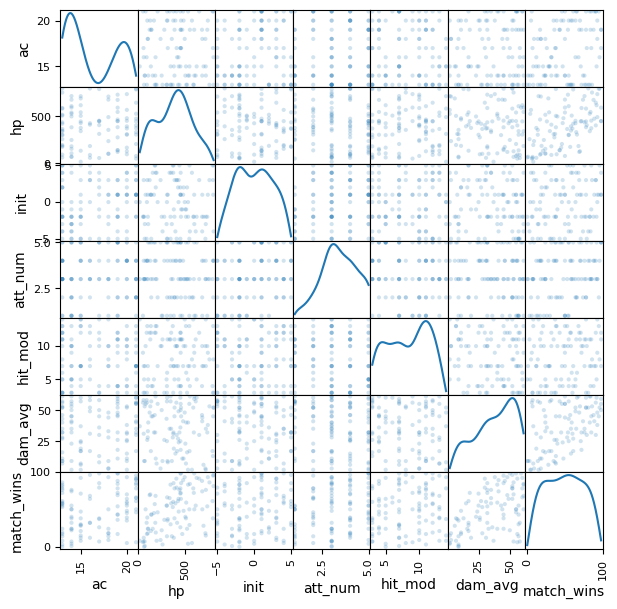

In [16]:
# ANALYZE THE GRAPH TO SEE THE DISTRIBUTION OF VARIABLES AND THEIR COVARIABILITY IF ANY
randoms = pandas.read_csv('data/gen/randoms_100.csv')
ax = pandas.plotting.scatter_matrix(randoms.drop(['name','cr','Unnamed: 0','round_wins','calc_wins'],axis=1),alpha=0.2, figsize=(7, 7), diagonal='kde')

### Correlation between ac and wins: randomly-generated creatures

r=0.291452

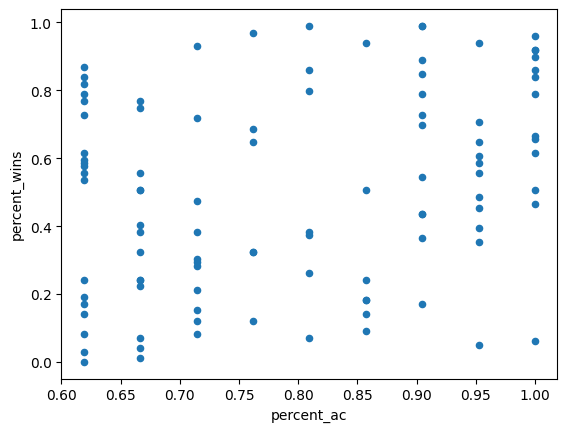

In [17]:
plot_correl('data/gen/randoms_100.csv','ac',subtitle='randomly-generated creatures')

### Correlation between init and wins: randomly-generated creatures

r=0.165665

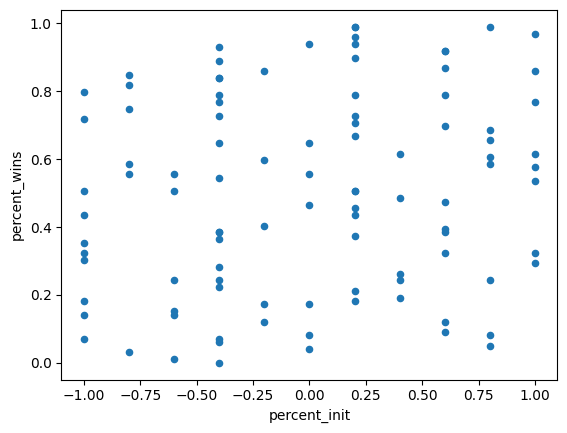

In [18]:
plot_correl('data/gen/randoms_100.csv','init',subtitle='randomly-generated creatures')

### Correlation between hit_mod and wins: randomly-generated creatures

r=0.130553

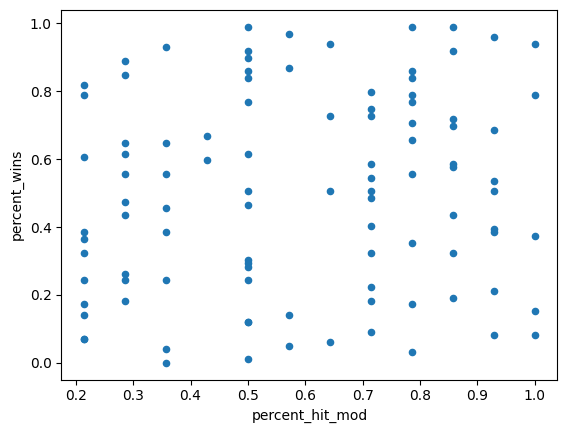

In [19]:
plot_correl('data/gen/randoms_100.csv','hit_mod',subtitle='randomly-generated creatures')

### Correlation between att_num and wins: randomly-generated creatures

r=0.236859

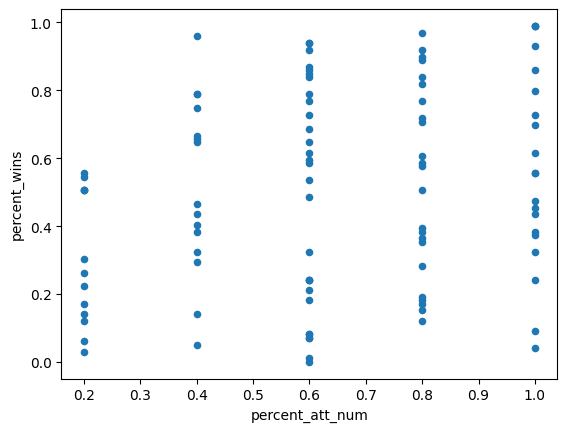

In [20]:
plot_correl('data/gen/randoms_100.csv','att_num',subtitle='randomly-generated creatures')

### Correlation between dam_avg and wins: randomly-generated creatures

r=0.493395

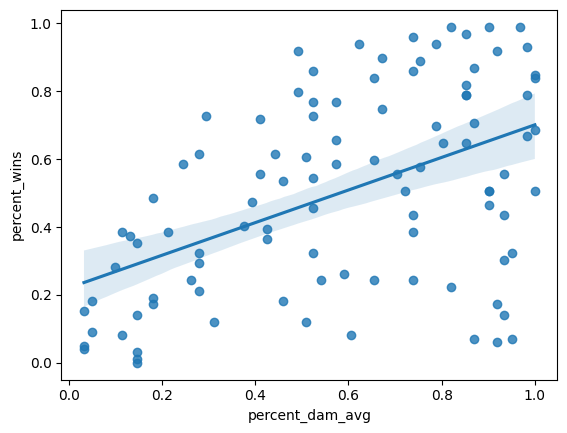

In [21]:
plot_correl('data/gen/randoms_100.csv','dam_avg',subtitle='randomly-generated creatures')

### Correlation between dam_max and wins: randomly-generated creatures

r=0.589323

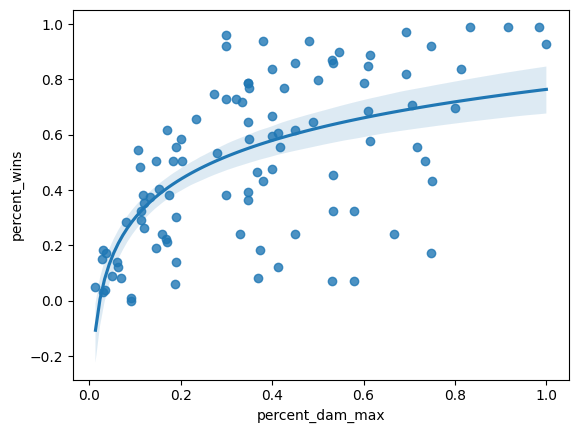

In [22]:
randoms = pandas.read_csv('data/gen/randoms_100.csv')
randoms['dam_max'] = randoms['dam_avg'] * randoms['att_num']
plot_correl_df(randoms,'dam_max',logx=True,subtitle='randomly-generated creatures')

### Correlation between hp and wins: randomly-generated creatures

r=0.504179

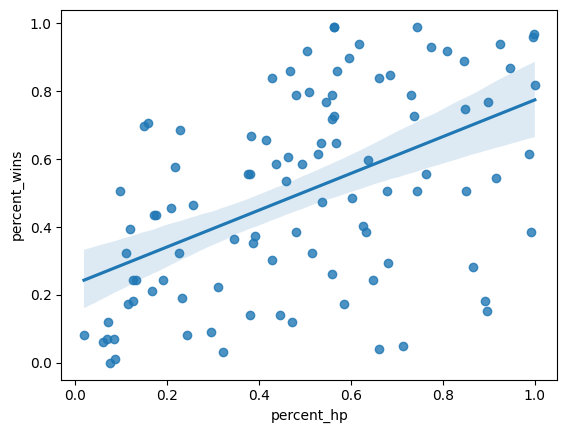

In [23]:
plot_correl('data/gen/randoms_100.csv','hp',subtitle='randomly-generated creatures')

### Correlation between hp_dam and wins: randomly-generated creatures

r=0.899820

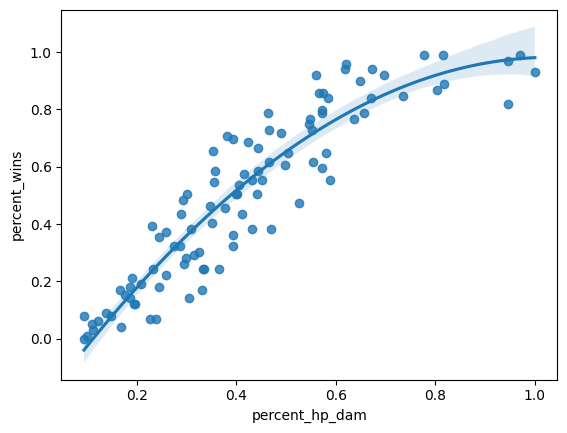

In [24]:
randoms = pandas.read_csv('data/gen/randoms_100.csv')
randoms['dam_max'] = randoms['dam_avg'] * randoms['att_num']
randoms['hp_dam'] = np.sqrt(randoms['dam_max'] * randoms['hp'])
plot_correl_df(randoms,'hp_dam',order=2,subtitle='randomly-generated creatures')

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis (Results may differ if notebook was rerun)</h1>
    <ol>
        <li>Stats that least affected win rates were initiative, hit_mod, and att_num</li>
        <li>Individual stats yield a lesser r compared to combining stats.</li>
        <li>Stat combinations that most affected win rate were those with good balance of hp and damage output</li>
    </ol>
</div>

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Comparing 100 Random Creatures Performance W/O Crit</h1>
    <ol>
        <li>Disable the global crit rules flag</li>
        <li>Repeat same process as above</li>
        <ol>
            <li>Create the creatures w/o crit</li>
            <li>Evaluate and save their performance</li>
            <li>Plot their performance for analysis</li>
        </ol>
    </ol>
</div>

In [25]:
use_crit_rules = False
randoms_nocrit = create_randoms(100)
run_matches(randoms_nocrit,100,'randoms_nocrit')

FloatProgress(value=0.0, description='Contest: ', max=4950.0)

Performing 4950 matches of 100 rounds each
Completed 3245299 turns in 377 seconds


### Correlation between ac and wins: randomly-generated creatures (no crit rules)

r=0.104629

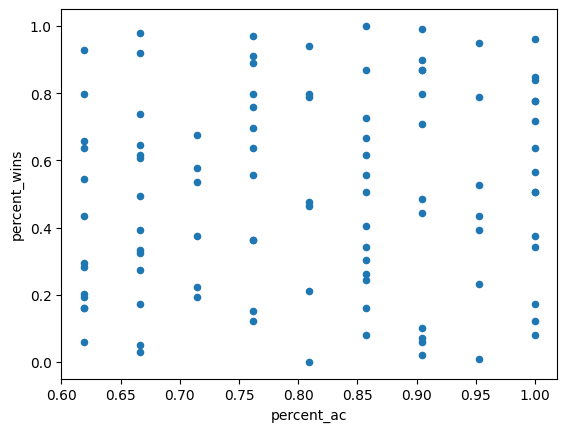

In [26]:
plot_correl('data/gen/randoms_nocrit_100.csv','ac',subtitle='randomly-generated creatures (no crit rules)')

### Correlation between init and wins: randomly-generated creatures (no crit rules)

r=0.011761

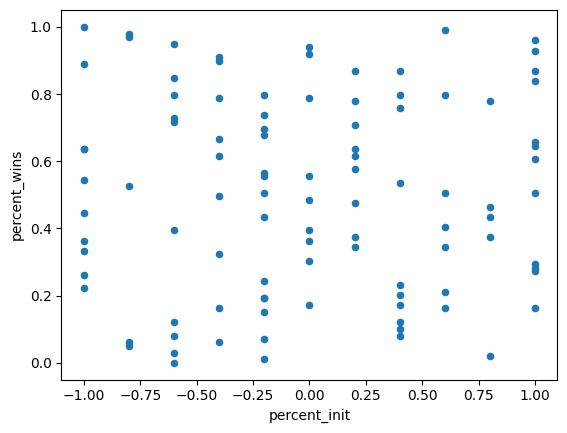

In [27]:
plot_correl('data/gen/randoms_nocrit_100.csv','init',subtitle='randomly-generated creatures (no crit rules)')

### Correlation between hit_mod and wins: randomly-generated creatures (no crit rules)

r=0.245009

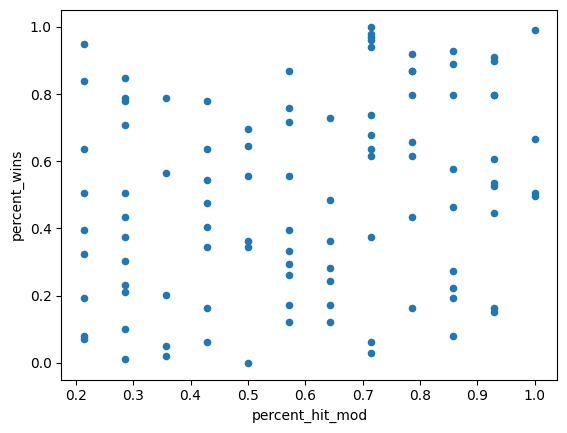

In [28]:
plot_correl('data/gen/randoms_nocrit_100.csv','hit_mod',subtitle='randomly-generated creatures (no crit rules)')

### Correlation between att_num and wins: randomly-generated creatures (no crit rules)

r=0.490194

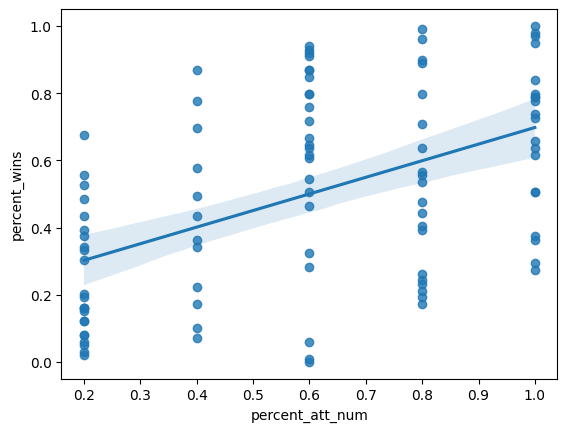

In [29]:
plot_correl('data/gen/randoms_nocrit_100.csv','att_num',subtitle='randomly-generated creatures (no crit rules)')

### Correlation between dam_avg and wins: randomly-generated creatures (no crit rules)

r=0.533276

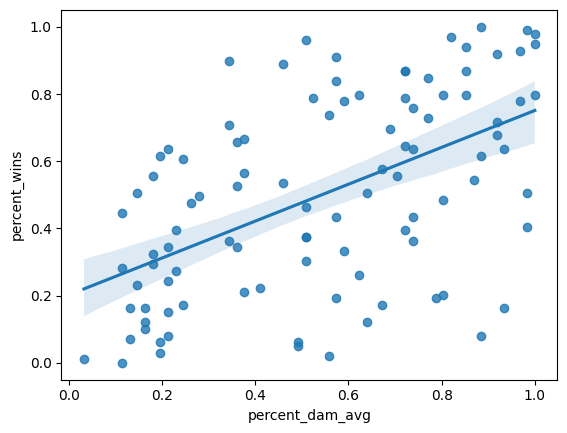

In [30]:
plot_correl('data/gen/randoms_nocrit_100.csv','dam_avg',subtitle='randomly-generated creatures (no crit rules)')

### Correlation between dam_max and wins: randomly-generated creatures (no crit rules)

r=0.671292

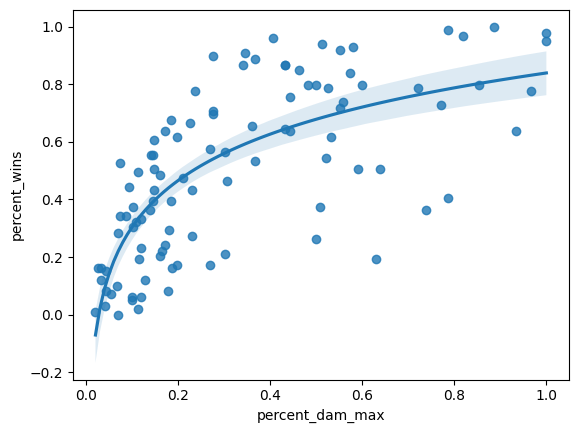

In [31]:
randoms_nocrit = pandas.read_csv('data/gen/randoms_nocrit_100.csv')
randoms_nocrit['dam_max'] = randoms_nocrit['dam_avg'] * randoms_nocrit['att_num']
plot_correl_df(randoms_nocrit,'dam_max',logx=True,subtitle='randomly-generated creatures (no crit rules)')

### Correlation between hp and wins: randomly-generated creatures (no crit rules)

r=0.596781

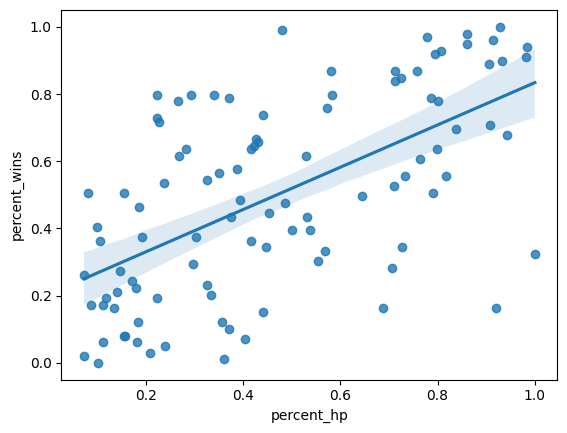

In [32]:
plot_correl('data/gen/randoms_nocrit_100.csv','hp',subtitle='randomly-generated creatures (no crit rules)')

### Correlation between hp_dam and wins: randomly-generated creatures (no crit rules)

r=0.911448

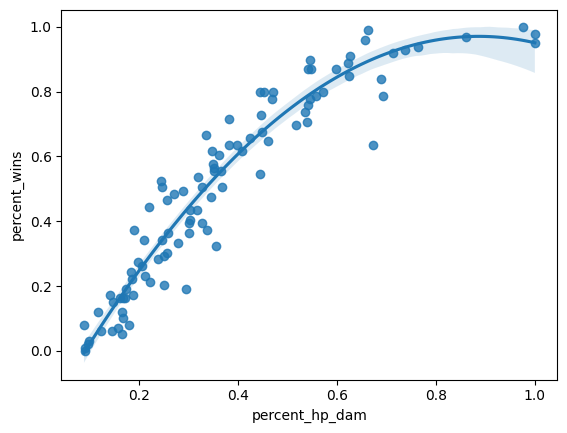

In [33]:
randoms_nocrit = pandas.read_csv('data/gen/randoms_nocrit_100.csv')
randoms_nocrit['dam_max'] = randoms_nocrit['dam_avg'] * randoms_nocrit['att_num']
randoms_nocrit['hp_dam'] = np.sqrt(randoms_nocrit['dam_max'] * randoms_nocrit['hp'])
plot_correl_df(randoms_nocrit,'hp_dam',order=2,subtitle='randomly-generated creatures (no crit rules)')

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis (Results may differ if notebook was rerun)</h1>
    <ol>
        <li>Stats were mostly the same as with crit on.
            <ul>
                <li>Individual stats had slightly lower r values.</li>
                <li>Combined stats had slightly higher r values.</li>
            </ul>
        </li>
        <li>Stats that least affected win rates was still initiative</li>
        <li>The stat combination that most affected win rate was still the good balance of hp and damage output</li>
    </ol>
</div>

In [34]:
# RESET THE GLOBAL CRIT FLAG
use_crit_rules = True

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Comparing generic/recommended character builds</h1>
    The following sections mostly involves reading the prepared csv's and observing correlations.<br>
    Assigned cr (challenge rating) data was included to indicate the overall stats scale/value of a creature.
    <br><br>Task: read the files containing the cr and win rate. Then plot using plot_correl()
    <br>Observe the correlation of cr to win rate
</div>

## Generic Characters and Creatures
In this experiment, we generate characters and creatures by level or challenge rating (respectively) using published guidelines, and run contests for each type of individual creature or party to ensure a strong correlation between challenge rating and combat success rate and even distribution/progression for that type.

### Generic Creatures
These creatures were generated using an interpretation of the guidelines on p. 274 of Dungeon Master's Guide (Wizards of the Coast, December 2014) in attempt to simulate a "typical" creature of each challenge rating from 0.125 - 30.

In [35]:
generics = pandas.read_csv('data/src/generics.csv')
run_matches(generics,100,'generics')

FloatProgress(value=0.0, description='Contest: ', max=528.0)

Performing 528 matches of 100 rounds each
Completed 131887 turns in 23 seconds


### Correlation between cr and wins: single monster

r=0.999187

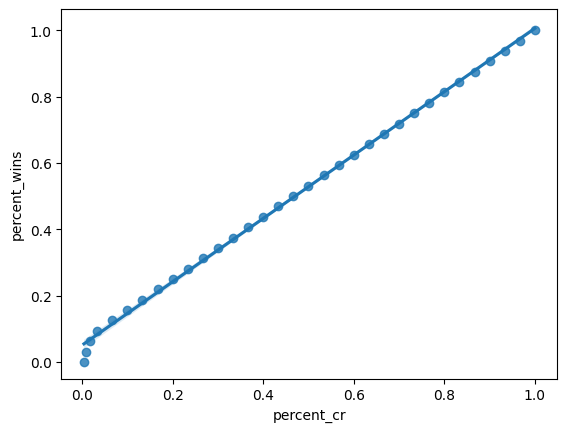

In [36]:
plot_correl('data/gen/generics_100.csv','cr',subtitle='single monster')

### Generic Party of Four Fighters
The level of a party of four characters is meant to correspond to the challenge rating of a comparable single creature, or the sum of challenge ratings of a group of creatures. The human fighter is [overwhelmingly the most popular character type](https://fivethirtyeight.com/features/is-your-dd-character-rare/), and arguably one of the most effective in melee combat. Here we assemble a party of four generic human fighters using an interpretation of the guidelines on pp. 70-75 of the Player's Handbook (Wizards of the Coast, August 2014). We exclude all but the most basic elements of character progress in relation to `hp`, `ac`, `att_num`, and `dam_avg`, assuming some upgrade in armour and ability score improvements (strength and constitution) as described.

In [37]:
fighters = pandas.read_csv('data/src/fighters.csv')
run_matches(fighters,100,'fighters')

FloatProgress(value=0.0, description='Contest: ', max=190.0)

Performing 190 matches of 100 rounds each
Completed 100113 turns in 34 seconds


### Correlation between cr and wins: party of 4 fighters

r=1.000000

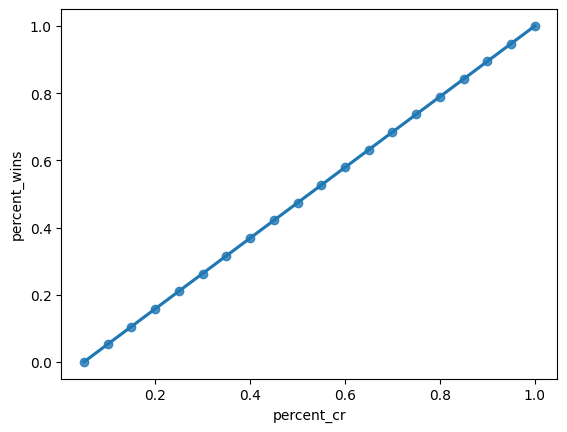

In [38]:
plot_correl('data/gen/fighters_100.csv','cr',subtitle='party of 4 fighters')

### Generic Party of Four Wizards
The elven wizard is [popular character type](https://fivethirtyeight.com/features/is-your-dd-character-rare/) that relies on spellcasting to make powerful attacks, and is generally amongst the most weak in melee combat. Here we assemble a party of four generic elven wizards using an interpretation of the guidelines on pp. 112-119 of the Player's Handbook (Wizards of the Coast, August 2014). In order to simulate a more accurate wizard, we allow this character to cast the shocking grasp cantrip, a melee attack spell whose attack modifier and damage output will progress as the character progresses. We exclude all but the most basic elements of character progress in relation to `hp`, `ac`, `att_num`, and `dam_avg`, assuming ability score improvements (intelligence and constitution) as described.

In [39]:
wizards = pandas.read_csv('data/src/wizards.csv')
run_matches(wizards,100,'wizards')

FloatProgress(value=0.0, description='Contest: ', max=190.0)

Performing 190 matches of 100 rounds each
Completed 58568 turns in 11 seconds


### Correlation between cr and wins: party of 4 wizards

r=0.993985

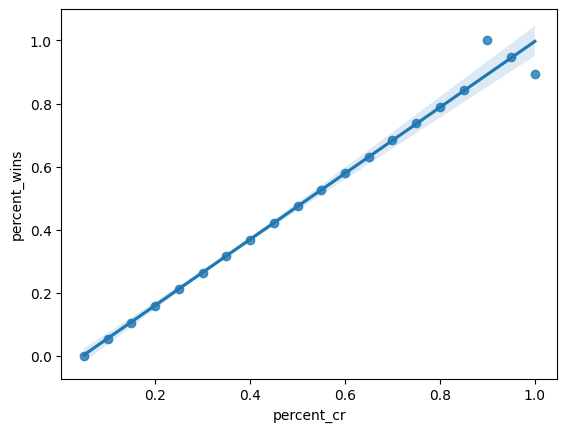

In [40]:
plot_correl('data/gen/wizards_100.csv','cr',subtitle='party of 4 wizards')

### Many Weaker Monsters
Since there is some positive correlation between number of attacks and combat effectiveness, here we assemble a group of between 1 and 30 monsters with a challenge rating of 1. This provides a linear increase in number of attacks far beyond that of a single typical CR 30 monster.

In [41]:
generics_to30 = pandas.read_csv('data/src/generics_to30.csv')
run_matches(generics_to30,100,'generics_to30')

FloatProgress(value=0.0, description='Contest: ', max=435.0)

Performing 435 matches of 100 rounds each
Completed 446628 turns in 240 seconds


### Correlation between cr and wins: 1-30 CR 1 monster(s)

r=1.000000

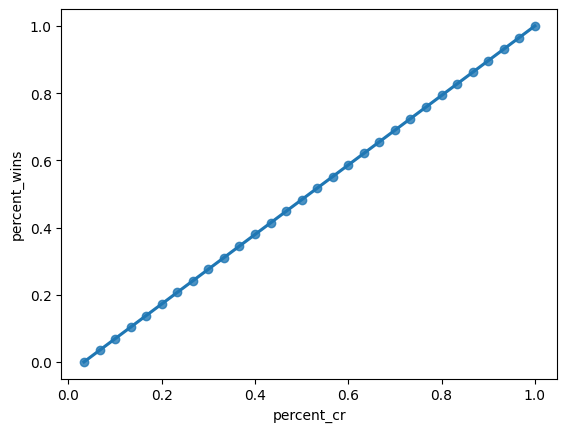

In [42]:
plot_correl('data/gen/generics_to30_100.csv','cr',subtitle='1-30 CR 1 monster(s)')

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis</h1>
    As observed, the challenge rating is a clear indicator with instances of perfect direct relationships r=1. 
    <br>This makes sense as higher stats would overpower opponents with weaker/lower stats.
    The same pattern was observed in all the graphs performed:
    <ol>
        <li>Fighters - Perfect relationship</li>
        <li>Wizards</li>
        <li>Generic monsters</li>
    </ol>
</div>

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Comparing mixed creatures and parties</h1>
    This section mostly is similar to above in analyzing the cr and win rate<br>
    <br>
    Main differnce is to 
    <ol>
        <li>combine the different creature types</li>
        <li>simulate their win rate</li>
        <li>and compare their performance.</li>
    </ol>
    <br>Once again, analyze if cr accurately depicts win rate.
    <br><br><i>Patch: Replace the outdated df.append() to pandas.concat()</i>
</div>

## Contests Between Characters and Creatures
### Party Characters versus Single Monster
Next, we run a contest between our party of four fighters, our party of four wizards, and our single monsters

In [43]:
# READ FIGHTERS, WIZARDS, AND GENERICS
fighters = pandas.read_csv('data/src/fighters.csv')
fighters['type'] = 'party of 4 fighters'
wizards = pandas.read_csv('data/src/wizards.csv')
wizards['type'] = 'party of 4 wizards'
generics = pandas.read_csv('data/src/generics.csv')
generics['type'] = 'single monster'

# mixed = generics.append(fighters).append(wizards)
mixed = pandas.concat([generics, fighters, wizards])
mixed = mixed.reset_index(drop=True)
run_matches(mixed,100,'characters_monster')

FloatProgress(value=0.0, description='Contest: ', max=2628.0)

Performing 2628 matches of 100 rounds each
Completed 820149 turns in 183 seconds


### Correlation between cr and wins: party of 4 characters and single generic monsters

r=0.920197

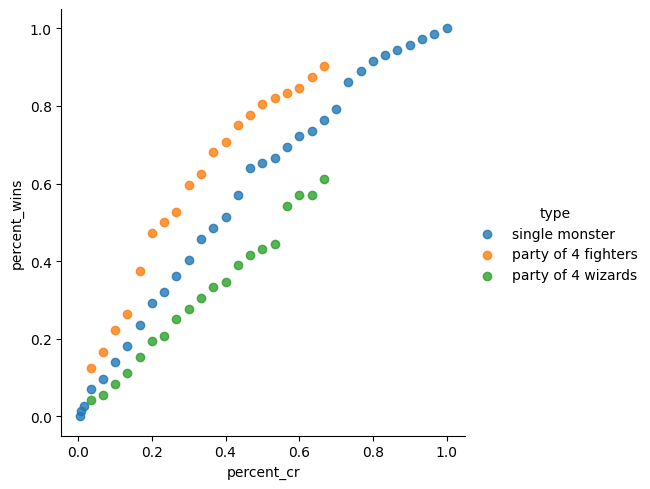

In [44]:
plot_correl('data/gen/characters_monster_100.csv','cr',subtitle='party of 4 characters and single generic monsters')

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis</h1>
    This graph allows us to observe up to cr20 figthers, cr20 wizards, and cr30 monsters.
    <ol>
        <li>Figthers scale the fastest, monsters scale mediocre, and wizards are the slowest.</li>
        <li>Wizards are easily overshadowed should they follow the current cr rules.</li>
        <li>Monsters require a few more levels before surpassing the fighter</li>
    </ol>
</div>

### Party of Characters versus Many Weaker Monsters
We then run a contest between our party of four fighers, party of four wizards, and 1-30 CR 1 monsters

In [45]:
fighters = pandas.read_csv('data/src/fighters.csv')
fighters['type'] = 'party of 4 fighters'
wizards = pandas.read_csv('data/src/wizards.csv')
wizards['type'] = 'party of 4 wizards'
generics_to30 = pandas.read_csv('data/src/generics_to30.csv')
generics_to30['type'] = '1-30 CR 1 monster(s)'

# mixed_to30 = generics_to30.append(fighters).append(wizards)
mixed_to30 = pandas.concat([generics_to30, fighters, wizards])
mixed_to30 = mixed_to30.reset_index(drop=True)
run_matches(mixed_to30,100,'characters_to30monsters')

FloatProgress(value=0.0, description='Contest: ', max=2415.0)

Performing 2415 matches of 100 rounds each
Completed 1342187 turns in 536 seconds


### Correlation between cr and wins: party of 4 characters and 1-30 CR 1 monsters

r=0.883278

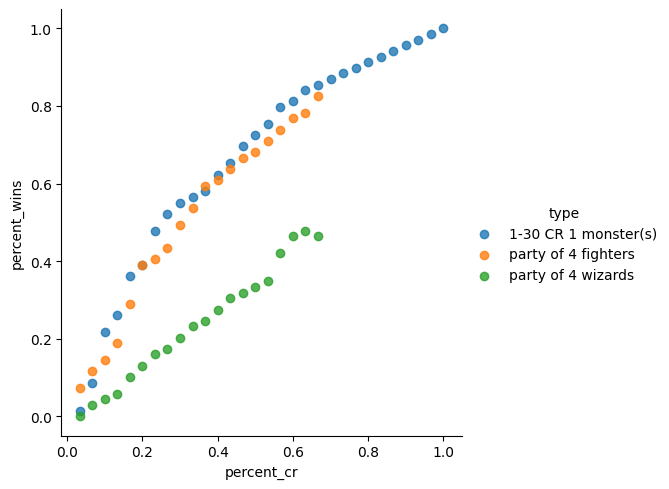

In [46]:
mixed_to30 = pandas.read_csv('data/gen/characters_to30monsters_100.csv')
plot_correl_df(mixed_to30,'cr',subtitle='party of 4 characters and 1-30 CR 1 monsters')

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis</h1>
    This graph allows us to observe up to cr20 figthers, cr20 wizards, and cr30 monsters.
    <ol>
        <li>Monsters are somewhat on par with fighter.</li>
        <li>Wiards are still extremely lacking and may need a buff.</li>
        <li>Monsters start to slow in in win chance after cr > 20</li>
    </ol>
</div>

### Party of Characters, Single Monster, and Many Weaker Monsters
We then run a contest between our party of four fighers, party of four wizards, single monsters, and 1-30 CR 1 monsters

In [47]:
generics = pandas.read_csv('data/src/generics.csv')
generics['type'] = 'single monster'
generics_to30 = pandas.read_csv('data/src/generics_to30.csv')
generics_to30['type'] = '1-30 CR 1 monster(s)'
fighters = pandas.read_csv('data/src/fighters.csv')
fighters['type'] = 'party of 4 fighters'
wizards = pandas.read_csv('data/src/wizards.csv')
wizards['type'] = 'party of 4 wizards'

# mixed_all = generics.append(generics_to30).append(fighters).append(wizards)
mixed_all = pandas.concat([generics, generics_to30, fighters, wizards])
mixed_all = mixed_all.reset_index(drop=True)
run_matches(mixed_all,100,'mixed_all')

FloatProgress(value=0.0, description='Contest: ', max=5253.0)

Performing 5253 matches of 100 rounds each
Completed 2314101 turns in 770 seconds


### Correlation between cr and wins: party of 4 characters, single monster, and 1-30 CR 1 monsters

r=0.919388

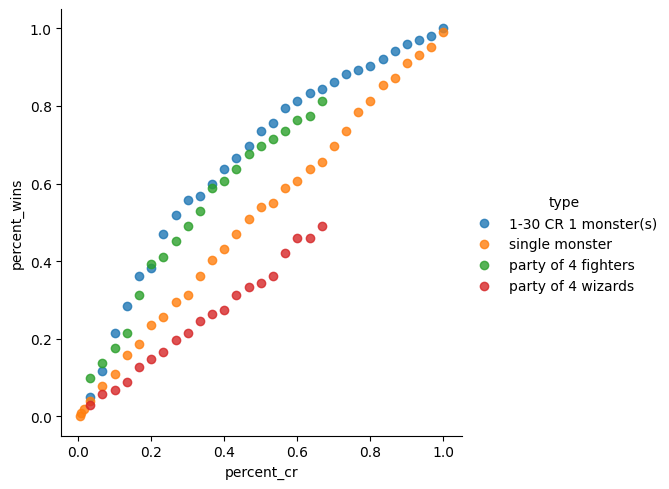

In [48]:
mixed_to30 = pandas.read_csv('data/gen/mixed_all_100.csv')
plot_correl_df(mixed_to30,'cr',subtitle='party of 4 characters, single monster, and 1-30 CR 1 monsters')

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis</h1>
    The graph combines the multiple parties and monster groups/solo.
    <ol>
        <li>Wizards are indeed the weakest.</li>
        <li>Figthers are still competitive enough with monsters.</li>
        <li>1-30 monsters hordes' win rate scales faster than single monsters</li>
    </ol>
</div>

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Comparing using a predicted cr</h1>
    This uses KNN to predict the cr. Note that all the models utilized <b>different creature groups</b> as to train and predict for.
    <ol>
        <li>Utilize knn_predict_cr to train from one creature set and predict onto another's cr</li>
        <li>Compute the correlation between the true cr and prediction.</li>
    </ol>
</div>

## Classifying fighters using k-nearest neighbours (k=5) trained on generic monsters

### Correlation between cr and predicted_cr

r=0.979563, a=0.150000

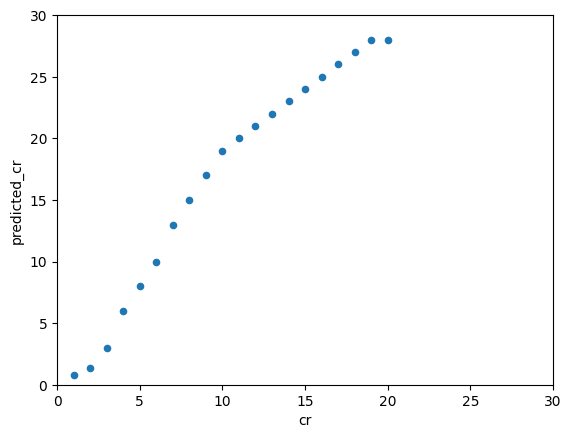

In [49]:
generics = pandas.read_csv('data/src/generics.csv')
fighters = pandas.read_csv('data/src/fighters.csv')
fighters = knn_predict_cr(generics,fighters)
display(Markdown('## Classifying fighters using k-nearest neighbours (k=5) trained on generic monsters'))
display(Markdown('### Correlation between %s and %s' % ('cr','predicted_cr')))
r = np.corrcoef(fighters['cr'],fighters['predicted_cr'])[0][1]
a = calc_success(fighters)
display(Markdown('r=%2f, a=%2f' % (r,a)))
ax = fighters.plot.scatter('cr','predicted_cr',ylim=(0,30),xlim=(0,30))

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis</h1>
    Fighters predictions do not match the generics training, as the predictions are way above the fighter's true cr.
    <br>The calc_success shows a very poor score, indicating they're very distant cr predictons.
    <br>It seems to say that a lvl20 figther would be equivalent to a lvl30 monster.
</div>

## Classifying wizards using k-nearest neighbours (k=5) trained on generic monsters

### Correlation between cr and predicted_cr

r=0.990688, a=0.550000

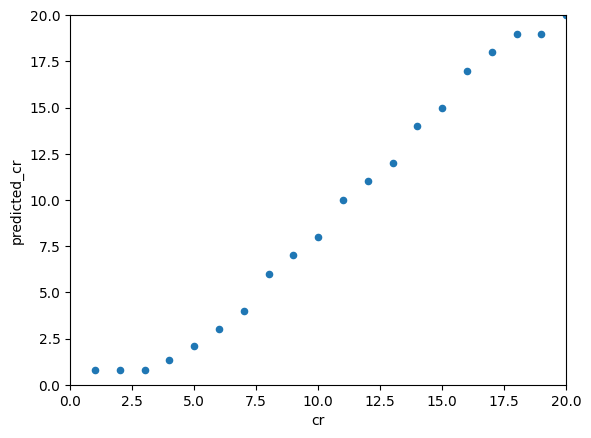

In [50]:
generics = pandas.read_csv('data/src/generics.csv')
wizards = pandas.read_csv('data/src/wizards.csv')
wizards = knn_predict_cr(generics,wizards)
display(Markdown('## Classifying wizards using k-nearest neighbours (k=5) trained on generic monsters'))
display(Markdown('### Correlation between %s and %s' % ('cr','predicted_cr')))
r = np.corrcoef(wizards['cr'],wizards['predicted_cr'])[0][1]
a = calc_success(wizards)
display(Markdown('r=%2f, a=%2f' % (r,a)))
ax = wizards.plot.scatter('cr','predicted_cr',ylim=(0,20),xlim=(0,20))

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis</h1>
    Wizards predictions are somewhat close to generics cr.
    <br>The overall graph seems to be more of a sigmoid with mediocre score.
</div>

## Classifying SRD monsters using k-nearest neighbours (k=5) trained on generic monsters

### Correlation between cr and predicted_cr

r=0.924585, a=0.515432

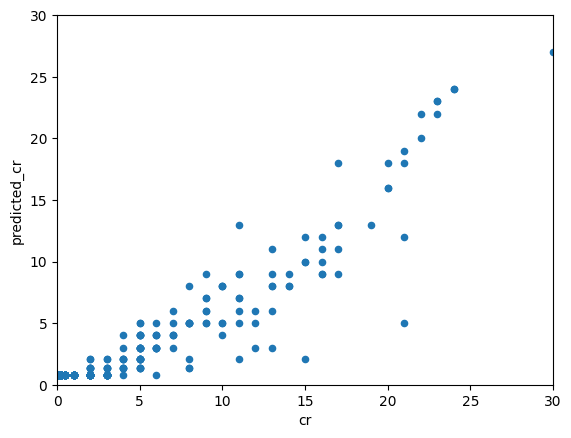

In [51]:
generics = pandas.read_csv('data/src/generics.csv')
creatures = pandas.read_csv('data/src/creatures.csv')
creatures = knn_predict_cr(generics,creatures)
display(Markdown('## Classifying SRD monsters using k-nearest neighbours (k=5) trained on generic monsters'))
display(Markdown('### Correlation between %s and %s' % ('cr','predicted_cr')))
r = np.corrcoef(creatures['cr'],creatures['predicted_cr'])[0][1]
a = calc_success(creatures)
display(Markdown('r=%2f, a=%2f' % (r,a)))
ax = creatures.plot.scatter('cr','predicted_cr',ylim=(0,30),xlim=(0,30))

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis</h1>
    Creatures predictions are lower than its true cr.
    <br>While the trend is correct, the distance is still far apart between prediction and true cr.
</div>

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Comparing true and predicted CR to Win Rate</h1>
    Compare results between the 2 methods
    <ol>
        <li>Use run_matches to simulate the creatures win rate.</li>
        <li>Fit a knn model using generics to predict for creatures.</li>
    </ol>
    Overall compare if the prediction trained on generics can match the true cr.
</div>

In [52]:
creatures = pandas.read_csv('data/src/creatures.csv')
run_matches(creatures,100,'creatures')

FloatProgress(value=0.0, description='Contest: ', max=52326.0)

Performing 52326 matches of 100 rounds each
Completed 25964743 turns in 2206 seconds


### Correlation between cr and wins: SRD monsters

r=0.749540

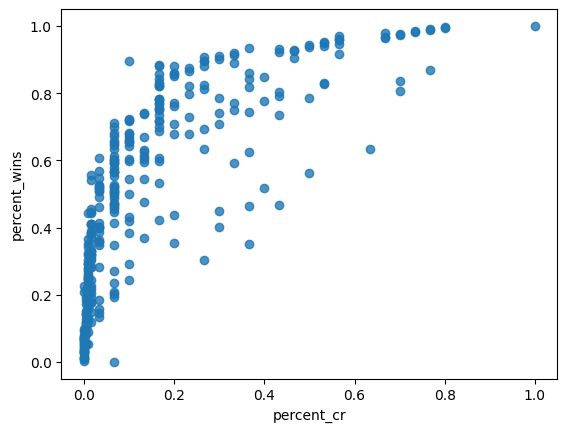

In [53]:
plot_correl('data/gen/creatures_100.csv','cr',subtitle='SRD monsters',logx=True)

### Correlation between predicted_cr and wins: SRD monsters

r=0.643948

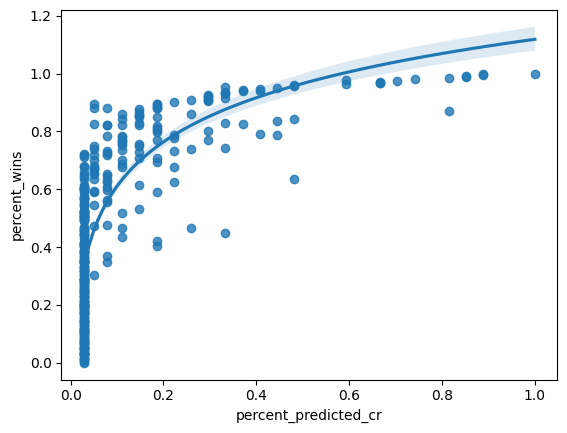

In [54]:
generics = pandas.read_csv('data/src/generics.csv')
creatures = pandas.read_csv('data/gen/creatures_100.csv')
creatures = knn_predict_cr(generics,creatures)
plot_correl_df(creatures,'predicted_cr',subtitle='SRD monsters',logx=True)

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis</h1>
    Surprisingly, the same pattern/trend can be observed from both simulation cr vs KNN prediction.
    <br>Creatures true cr seems to match the predictions trained from generics.
</div>

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Comparing progressive's CR and prediction</h1>
    Progressive dataframe consists of incrementing stat values.
</div>

In [55]:
progs = create_progressives(100,roll_adv)
run_matches(progs,100,'progs')

FloatProgress(value=0.0, description='Contest: ', max=4950.0)

Performing 4950 matches of 100 rounds each
Completed 1911429 turns in 220 seconds


### Correlation between predicted_cr and wins: progressively-increasing random monsters

r=0.971959

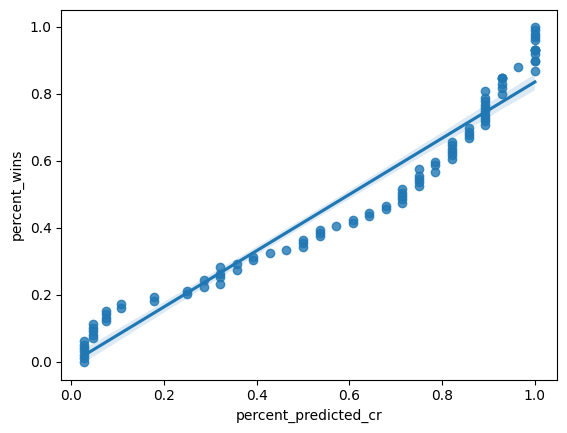

In [56]:
generics = pandas.read_csv('data/src/generics.csv')
creatures = pandas.read_csv('data/gen/progs_100.csv')
creatures = knn_predict_cr(generics,creatures)
plot_correl_df(creatures,'predicted_cr',subtitle='progressively-increasing random monsters')

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis</h1>
    Training on generics, produces close predictions for progressive predictions.
</div>

### Correlation between predicted_cr and wins: random monsters

r=0.525806

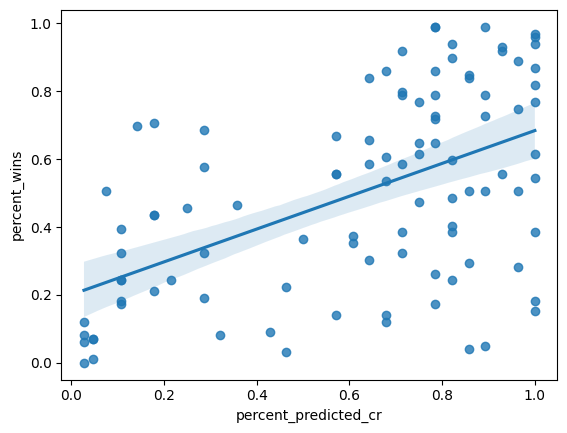

In [57]:
generics = pandas.read_csv('data/src/generics.csv')
creatures = pandas.read_csv('data/gen/randoms_100.csv')
creatures = knn_predict_cr(generics,creatures)
plot_correl_df(creatures,'predicted_cr',subtitle='random monsters')

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis</h1>
    Training on generics, produces very noisy predictions for randoms predictions.
</div>

## Classifying generic monsters using k-nearest neighbours (k=5) trained on SRD monsters

### Correlation between cr and predicted_cr

r=0.970567, a=0.212121

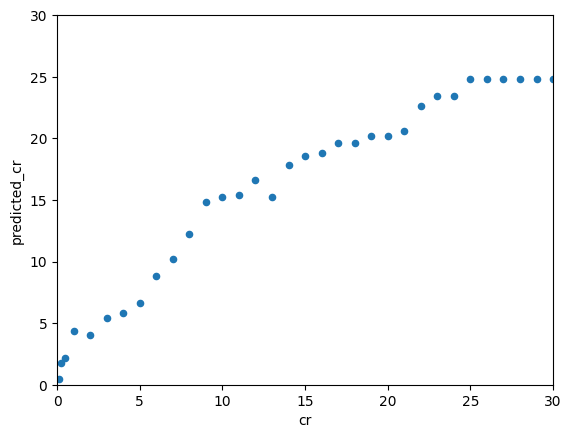

In [58]:
generics = pandas.read_csv('data/src/generics.csv')
creatures = pandas.read_csv('data/src/creatures.csv')
creatures = knn_predict_cr(creatures,generics)
display(Markdown('## Classifying generic monsters using k-nearest neighbours (k=5) trained on SRD monsters'))
display(Markdown('### Correlation between %s and %s' % ('cr','predicted_cr')))
r = np.corrcoef(creatures['cr'],creatures['predicted_cr'])[0][1]
a = calc_success(creatures)
display(Markdown('r=%2f, a=%2f' % (r,a)))
ax = creatures.plot.scatter('cr','predicted_cr',ylim=(0,30),xlim=(0,30))

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis</h1>
    Training on generics, produces poor cr predictions in creatures. While it's somewhat linear, the values are just too far off.
</div>

## Classifying SRD monsters using k-nearest neighbours (k=5) trained on SRD monsters

### Correlation between cr and predicted_cr

r=0.981873, a=0.846154

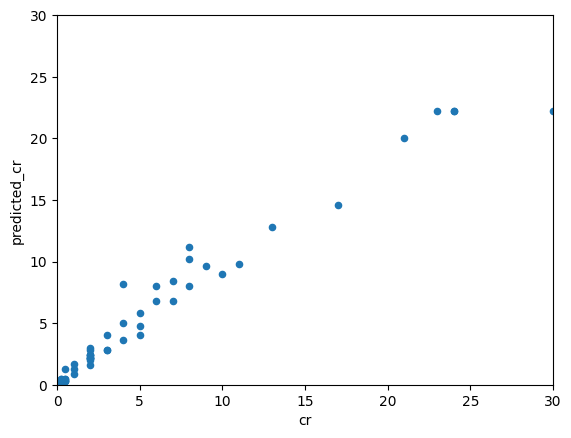

In [59]:
creatures = pandas.read_csv('data/src/creatures.csv')
train, test = train_test_split(creatures, test_size=0.2)
creatures = knn_predict_cr(train,test)
display(Markdown('## Classifying SRD monsters using k-nearest neighbours (k=5) trained on SRD monsters'))
display(Markdown('### Correlation between %s and %s' % ('cr','predicted_cr')))
r = np.corrcoef(creatures['cr'],creatures['predicted_cr'])[0][1]
a = calc_success(creatures)
display(Markdown('r=%2f, a=%2f' % (r,a)))
ax = creatures.plot.scatter('cr','predicted_cr',ylim=(0,30),xlim=(0,30))

<div style='background-color: #83B4FF; padding: 2px 0;'>
    <h1>Analysis</h1>
    Training creatures on a portion (train-test split) of itself produces good results.<br>The cr values below cr 10 are the most closest to correct. Perhaps straitfying the set imbalancecould have reduced the errors in cr > 10.
</div>